In [1]:
#!/usr/bin/env python
# coding: utf-8

import gym
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import random
import statistics
import time 

from torch import nn
from tqdm import tqdm
from scipy.optimize import minimize_scalar

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)  

        # Apply the weights initialization
        self.apply(self.init_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def act(self, state):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        q_values = self.forward(state_t.unsqueeze(0))  
        max_q_index = torch.argmax(q_values, dim=1)[0]   
        action = max_q_index.detach().item()   
        return action  

    def init_weights(self, m):
        if type(m) == nn.Linear:
            init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def inject_parameters(self, pvec):
        new_state_dict = {}
        count = 0
        for name, param in self.named_parameters():
            sz = param.data.numel()
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.data.shape)
            new_state_dict[name] = torch.from_numpy(reshaped).float()
            count += sz
        self.load_state_dict(new_state_dict)

In [3]:
def calculate_fitness(network, env, num_episodes):
    total_rewards = 0
    for _ in range(num_episodes):
        reward, _ = run_episode(network, env)
        total_rewards += reward
    avg_reward = total_rewards / num_episodes
    return avg_reward

def run_episode(network, env):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward, _

def select_survivors(population, fitnesses, ELITISM):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
    return sorted_population[:ELITISM]

def tournament_selection(population, fitnesses, tournament_size):
    selected_indices = np.random.randint(len(population), size=tournament_size)
    selected_fitnesses = [fitnesses[i] for i in selected_indices]
    winner_index = selected_indices[np.argmax(selected_fitnesses)]
    return population[winner_index]

def perturb_parameters(network, weight_clip, n_episodes):
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        current_output = None

        while not done:
            if episode == 0 and current_output is None:
                prev_output = torch.Tensor([0.25, 0.25, 0.25, 0.25])
            else:
                prev_output = current_output.detach()

            current_param = torch.cat([param.view(-1) for param in network.parameters()])

            delta = torch.randn_like(current_param)

            current_output = network(torch.from_numpy(state).float().unsqueeze(0))

            error = ((current_output - prev_output)**2).mean()

            network.zero_grad()

            error.backward()

            gradient = torch.cat([param.grad.view(-1) for param in network.parameters()])

            gradient /= ((gradient**2).sum() + 1e-10)

            perturbation = np.clip(delta * gradient, -weight_clip, weight_clip)
            new_param = current_param + perturbation

            network.inject_parameters(new_param.detach().numpy())

            action = torch.argmax(network(torch.from_numpy(state).float().unsqueeze(0))).item()
            state, reward, done, _ = env.step(action)

In [4]:
# Constants
POPULATION_SIZE = 200 
GENERATIONS = 150
ELITISM = int(POPULATION_SIZE * 0.4)
TOURNAMENT_SIZE = 5
WEIGHT_CLIP = 0.5
INPUT_DIM = 8  # For LunarLander environment
OUTPUT_DIM = 4  # For LunarLander environment
MAX_EP = 1

FITNESS_HISTORY = list()
FITNESS_STDERROR_HISTORY = list()

env = gym.make("LunarLander-v2")

population = [PolicyNetwork(INPUT_DIM, OUTPUT_DIM) for _ in range(POPULATION_SIZE)]

/Users/jinhyunpark/miniforge3/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
start_time = time.time()

In [6]:
for generation in range(GENERATIONS):
    print(f"[Generation {generation}]")
    
    print("Calculating Fitnesses For Population ...")
    fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population)]
    
    avg_fitness = np.average(fitnesses)
    max_fitness = np.max(fitnesses)
    min_fitness = np.min(fitnesses)
    FITNESS_HISTORY.append([avg_fitness, max_fitness, min_fitness])
    
    standard_deviation = statistics.stdev(fitnesses)
    standard_error = standard_deviation / (POPULATION_SIZE ** 0.5)
    FITNESS_STDERROR_HISTORY.append(standard_error)
    
    print(f"Average Fitness: {avg_fitness} \n Best Fitness: {max_fitness} \n Worst Fitness: {min_fitness} \n Standard Error: {standard_error}")

    survivors = select_survivors(population, fitnesses, ELITISM)

    next_population = survivors  

    for _ in tqdm(range(POPULATION_SIZE - len(survivors))):
        parent = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
        offspring = copy.deepcopy(parent)
        perturb_parameters(offspring, WEIGHT_CLIP, MAX_EP)
        next_population.append(offspring)

    population = next_population

[Generation 0]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 101.48it/s]


Average Fitness: -477.0699003021322 
 Best Fitness: 44.36967681672354 
 Worst Fitness: -1824.0123931261292 
 Standard Error: 21.429123173805607


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.66it/s]


[Generation 1]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.53it/s]


Average Fitness: -449.17201094870046 
 Best Fitness: 22.004167051337618 
 Worst Fitness: -2923.3609925183373 
 Standard Error: 26.224375109523464


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.68it/s]


[Generation 2]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 123.65it/s]


Average Fitness: -345.91066741949885 
 Best Fitness: 40.61943999933976 
 Worst Fitness: -1728.6521418508696 
 Standard Error: 20.803244132878042


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.03it/s]


[Generation 3]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 146.50it/s]


Average Fitness: -285.01229270766316 
 Best Fitness: 20.48555389078666 
 Worst Fitness: -1912.6951599257181 
 Standard Error: 18.928305966701313


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.14it/s]


[Generation 4]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.23it/s]


Average Fitness: -265.0954521611235 
 Best Fitness: 143.7972894023862 
 Worst Fitness: -2009.4285448613532 
 Standard Error: 20.26844017956906


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 31.07it/s]


[Generation 5]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 154.12it/s]


Average Fitness: -256.64256388296917 
 Best Fitness: 202.26628707161996 
 Worst Fitness: -2126.267835218809 
 Standard Error: 18.577248804020204


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.87it/s]


[Generation 6]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 153.41it/s]


Average Fitness: -199.32382872482958 
 Best Fitness: 214.57257675178124 
 Worst Fitness: -3282.274512036092 
 Standard Error: 19.010930995731368


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.47it/s]


[Generation 7]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:00<00:00, 202.20it/s]


Average Fitness: -183.68431146925587 
 Best Fitness: 4.340666658082085 
 Worst Fitness: -877.997370442783 
 Standard Error: 10.439639917788336


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 33.02it/s]


[Generation 8]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 167.69it/s]


Average Fitness: -181.44140964166715 
 Best Fitness: 17.589907127827402 
 Worst Fitness: -1221.2941650783384 
 Standard Error: 11.971064634659843


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.06it/s]


[Generation 9]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 171.61it/s]


Average Fitness: -176.35831561822445 
 Best Fitness: 32.7723938093699 
 Worst Fitness: -1815.1170097001868 
 Standard Error: 13.0200117355337


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 32.44it/s]


[Generation 10]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 181.53it/s]


Average Fitness: -146.89296122770207 
 Best Fitness: 60.27862587591184 
 Worst Fitness: -1761.4467098565867 
 Standard Error: 10.440090970253122


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.14it/s]


[Generation 11]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 171.86it/s]


Average Fitness: -157.82846508266192 
 Best Fitness: 23.984614031443428 
 Worst Fitness: -899.5470261165467 
 Standard Error: 8.559799619484362


100%|██████████████████████████████████████████████████████| 120/120 [00:03<00:00, 30.51it/s]


[Generation 12]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 151.51it/s]


Average Fitness: -154.08117369714756 
 Best Fitness: 10.940033378810384 
 Worst Fitness: -1005.8854006551366 
 Standard Error: 8.306435663385237


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.03it/s]


[Generation 13]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 156.81it/s]


Average Fitness: -168.39337500232 
 Best Fitness: 208.8317379251955 
 Worst Fitness: -1278.9301948769307 
 Standard Error: 13.390499266863005


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.90it/s]


[Generation 14]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 144.82it/s]


Average Fitness: -154.32510324785298 
 Best Fitness: 31.16860766284543 
 Worst Fitness: -959.9802737465255 
 Standard Error: 9.159919908232643


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.40it/s]


[Generation 15]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 158.57it/s]


Average Fitness: -151.96213101157971 
 Best Fitness: 40.32062124702463 
 Worst Fitness: -1226.3869939628112 
 Standard Error: 9.315315951403887


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.97it/s]


[Generation 16]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 162.24it/s]


Average Fitness: -143.18592259863632 
 Best Fitness: 51.6117947136878 
 Worst Fitness: -1044.133084380975 
 Standard Error: 8.368739982668888


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.65it/s]


[Generation 17]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 165.03it/s]


Average Fitness: -138.86088393190073 
 Best Fitness: 27.95295981520877 
 Worst Fitness: -573.3620461664659 
 Standard Error: 6.813390821940703


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.47it/s]


[Generation 18]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 148.63it/s]


Average Fitness: -126.60016621107239 
 Best Fitness: 224.44871516654104 
 Worst Fitness: -782.2976673840568 
 Standard Error: 7.713204886204978


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.18it/s]


[Generation 19]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.63it/s]


Average Fitness: -151.75119149985187 
 Best Fitness: 204.86714180690265 
 Worst Fitness: -3189.2590457867936 
 Standard Error: 17.232237380750437


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.93it/s]


[Generation 20]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.75it/s]


Average Fitness: -119.98846616401457 
 Best Fitness: 267.1219692081087 
 Worst Fitness: -1431.18800550692 
 Standard Error: 10.527281563757654


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.82it/s]


[Generation 21]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 155.98it/s]


Average Fitness: -148.09653363054852 
 Best Fitness: 17.961527273170518 
 Worst Fitness: -606.0694795176447 
 Standard Error: 8.25553020633943


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.08it/s]


[Generation 22]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 149.27it/s]


Average Fitness: -119.70366164508857 
 Best Fitness: 150.592112350839 
 Worst Fitness: -492.9810567765068 
 Standard Error: 6.336805675427243


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.80it/s]


[Generation 23]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.59it/s]


Average Fitness: -129.40976697200236 
 Best Fitness: 228.76470219369122 
 Worst Fitness: -1352.9040321738755 
 Standard Error: 10.65608492428053


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.41it/s]


[Generation 24]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.98it/s]


Average Fitness: -109.57971110383113 
 Best Fitness: 273.76510276772626 
 Worst Fitness: -1235.7134095668496 
 Standard Error: 9.00166072719093


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.32it/s]


[Generation 25]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.44it/s]


Average Fitness: -123.3076136696478 
 Best Fitness: 221.77147818170437 
 Worst Fitness: -613.1444398440327 
 Standard Error: 7.616269555128268


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.40it/s]


[Generation 26]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.05it/s]


Average Fitness: -128.25905232806383 
 Best Fitness: 31.806118235988464 
 Worst Fitness: -1179.3448326644736 
 Standard Error: 9.280658731380461


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.13it/s]


[Generation 27]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.56it/s]


Average Fitness: -119.44460108195682 
 Best Fitness: 208.9078766245483 
 Worst Fitness: -1632.3669299544276 
 Standard Error: 10.639900656103453


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.69it/s]


[Generation 28]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.43it/s]


Average Fitness: -125.67471846931002 
 Best Fitness: 49.43930838083406 
 Worst Fitness: -748.8056294633558 
 Standard Error: 8.198485235236213


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.01it/s]


[Generation 29]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.35it/s]


Average Fitness: -138.1588199064736 
 Best Fitness: 164.42467968875786 
 Worst Fitness: -946.2136691236948 
 Standard Error: 9.0376736960094


100%|██████████████████████████████████████████████████████| 120/120 [00:06<00:00, 19.16it/s]


[Generation 30]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 134.66it/s]


Average Fitness: -136.22644174504342 
 Best Fitness: 43.83067983218589 
 Worst Fitness: -776.1366004966452 
 Standard Error: 9.233573060773372


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.57it/s]


[Generation 31]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.97it/s]


Average Fitness: -123.40245571204818 
 Best Fitness: 41.75007915603874 
 Worst Fitness: -625.7042838789156 
 Standard Error: 8.014481585693257


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.52it/s]


[Generation 32]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 132.81it/s]


Average Fitness: -110.71632205590302 
 Best Fitness: 286.3921412080307 
 Worst Fitness: -333.22188798836453 
 Standard Error: 7.264080932910687


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.06it/s]


[Generation 33]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.37it/s]


Average Fitness: -125.12872704142528 
 Best Fitness: 46.80671287944048 
 Worst Fitness: -807.040640913583 
 Standard Error: 8.01106795500781


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.97it/s]


[Generation 34]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.13it/s]


Average Fitness: -116.16139623109511 
 Best Fitness: 44.36520791588674 
 Worst Fitness: -686.7823674809445 
 Standard Error: 7.373877787501087


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.27it/s]


[Generation 35]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 149.61it/s]


Average Fitness: -103.70876263133862 
 Best Fitness: 62.93429200285689 
 Worst Fitness: -451.444712918651 
 Standard Error: 6.343029702275401


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.07it/s]


[Generation 36]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 144.55it/s]


Average Fitness: -100.71630929154453 
 Best Fitness: 29.09441340311696 
 Worst Fitness: -401.89376994861954 
 Standard Error: 5.988931580855947


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.41it/s]


[Generation 37]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 134.65it/s]


Average Fitness: -121.27141239610818 
 Best Fitness: 190.49557103441686 
 Worst Fitness: -646.7644753536383 
 Standard Error: 8.072209363844289


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.25it/s]


[Generation 38]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 132.85it/s]


Average Fitness: -125.8820533332509 
 Best Fitness: 27.29855861158066 
 Worst Fitness: -736.9852662918044 
 Standard Error: 8.495037128411465


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.20it/s]


[Generation 39]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.85it/s]


Average Fitness: -137.0504532101524 
 Best Fitness: 26.016275955279085 
 Worst Fitness: -533.1106544610548 
 Standard Error: 7.8401310804217585


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.37it/s]


[Generation 40]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 155.19it/s]


Average Fitness: -103.10786069036818 
 Best Fitness: 27.79552558378569 
 Worst Fitness: -432.7504517574139 
 Standard Error: 5.529496978181382


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 29.73it/s]


[Generation 41]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 155.00it/s]


Average Fitness: -107.0735756811063 
 Best Fitness: 52.08173893145397 
 Worst Fitness: -388.46989729455646 
 Standard Error: 5.776993796490104


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.06it/s]


[Generation 42]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 149.36it/s]


Average Fitness: -106.33410458017133 
 Best Fitness: 242.02618103940085 
 Worst Fitness: -430.8218122839064 
 Standard Error: 6.457925514806149


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.05it/s]


[Generation 43]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 147.96it/s]


Average Fitness: -111.64385459753616 
 Best Fitness: 25.08440185315071 
 Worst Fitness: -522.6495968784371 
 Standard Error: 6.7558403751961835


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 28.19it/s]


[Generation 44]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.05it/s]


Average Fitness: -112.14736100599261 
 Best Fitness: 42.647587285856844 
 Worst Fitness: -526.2728732826396 
 Standard Error: 7.1260614335008725


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.79it/s]


[Generation 45]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 147.40it/s]


Average Fitness: -114.67988414423118 
 Best Fitness: 57.241528238133924 
 Worst Fitness: -451.7112762355281 
 Standard Error: 6.9309022777167


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.44it/s]


[Generation 46]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.05it/s]


Average Fitness: -105.10691382879226 
 Best Fitness: 218.7195446871637 
 Worst Fitness: -363.03738806921444 
 Standard Error: 7.120004820162125


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.31it/s]


[Generation 47]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.35it/s]


Average Fitness: -98.27388738048798 
 Best Fitness: 49.73328747649049 
 Worst Fitness: -570.7920679497668 
 Standard Error: 6.794184393922544


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.69it/s]


[Generation 48]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.52it/s]


Average Fitness: -112.18544672865319 
 Best Fitness: 23.451326547952007 
 Worst Fitness: -492.7014411260821 
 Standard Error: 7.559252554532424


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.41it/s]


[Generation 49]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 132.52it/s]


Average Fitness: -116.9029251672099 
 Best Fitness: 54.82449902641537 
 Worst Fitness: -498.1915062814319 
 Standard Error: 7.646744634214103


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 27.57it/s]


[Generation 50]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 131.79it/s]


Average Fitness: -113.46006985173216 
 Best Fitness: 194.2926030183769 
 Worst Fitness: -558.6704232401896 
 Standard Error: 7.5756512566684036


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.23it/s]


[Generation 51]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.87it/s]


Average Fitness: -114.95974575113658 
 Best Fitness: 206.14199654062352 
 Worst Fitness: -458.99774575179856 
 Standard Error: 7.553737867961189


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.24it/s]


[Generation 52]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.65it/s]


Average Fitness: -112.44746679670908 
 Best Fitness: 30.879688708805162 
 Worst Fitness: -574.041824696125 
 Standard Error: 7.357797133625167


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.24it/s]


[Generation 53]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.69it/s]


Average Fitness: -113.99977128602885 
 Best Fitness: 45.664050361807085 
 Worst Fitness: -499.05512793746306 
 Standard Error: 7.623284143691263


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.86it/s]


[Generation 54]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 123.96it/s]


Average Fitness: -123.54854054641133 
 Best Fitness: 45.048596409578806 
 Worst Fitness: -488.21049908352285 
 Standard Error: 8.017029866541883


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.87it/s]


[Generation 55]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.96it/s]


Average Fitness: -107.42353882423524 
 Best Fitness: 44.6805627567266 
 Worst Fitness: -523.8687328488256 
 Standard Error: 7.233122463837717


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.85it/s]


[Generation 56]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.89it/s]


Average Fitness: -98.80109753539583 
 Best Fitness: 223.14710464558374 
 Worst Fitness: -468.0965590967955 
 Standard Error: 7.868937795551144


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.94it/s]


[Generation 57]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.73it/s]


Average Fitness: -107.36925398196222 
 Best Fitness: 261.094071522794 
 Worst Fitness: -635.2703298301783 
 Standard Error: 8.07574723688261


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.86it/s]


[Generation 58]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.94it/s]


Average Fitness: -112.8836501803837 
 Best Fitness: 37.806575616817724 
 Worst Fitness: -664.702815928056 
 Standard Error: 8.787222820371591


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.62it/s]


[Generation 59]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.18it/s]


Average Fitness: -122.90973225339626 
 Best Fitness: 221.04341052595305 
 Worst Fitness: -445.4350084182802 
 Standard Error: 7.625149630737507


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.69it/s]


[Generation 60]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 123.94it/s]


Average Fitness: -122.47505341205641 
 Best Fitness: 45.479258408269146 
 Worst Fitness: -610.704696846963 
 Standard Error: 7.917266639984031


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.82it/s]


[Generation 61]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 123.18it/s]


Average Fitness: -109.9788478327673 
 Best Fitness: 191.4764422098355 
 Worst Fitness: -521.7410403562792 
 Standard Error: 8.282826201601944


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.71it/s]


[Generation 62]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 124.76it/s]


Average Fitness: -115.42952909489793 
 Best Fitness: 42.556755098114536 
 Worst Fitness: -511.5063471724483 
 Standard Error: 8.174865014868248


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.97it/s]


[Generation 63]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.74it/s]


Average Fitness: -105.22537332573113 
 Best Fitness: 171.3714084345662 
 Worst Fitness: -442.35668906767586 
 Standard Error: 7.76360366672123


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.86it/s]


[Generation 64]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.82it/s]


Average Fitness: -100.42654999218612 
 Best Fitness: 242.8644359421106 
 Worst Fitness: -396.9505173236585 
 Standard Error: 7.4790714165343966


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.44it/s]


[Generation 65]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.65it/s]


Average Fitness: -104.81117282434423 
 Best Fitness: 47.979839073688765 
 Worst Fitness: -468.12370467377445 
 Standard Error: 7.7336217535140035


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.35it/s]


[Generation 66]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.17it/s]


Average Fitness: -93.07964239704222 
 Best Fitness: 158.6216272824115 
 Worst Fitness: -441.5425336517816 
 Standard Error: 6.580741648814571


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.72it/s]


[Generation 67]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.52it/s]


Average Fitness: -108.54064243585356 
 Best Fitness: 47.33931907479371 
 Worst Fitness: -571.173687978594 
 Standard Error: 8.039946410496123


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.83it/s]


[Generation 68]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.94it/s]


Average Fitness: -94.77735260481793 
 Best Fitness: 229.01896463233447 
 Worst Fitness: -483.46121127656664 
 Standard Error: 7.417431925849058


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.32it/s]


[Generation 69]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 124.25it/s]


Average Fitness: -108.71733736700244 
 Best Fitness: 61.85370394662618 
 Worst Fitness: -625.1892625645575 
 Standard Error: 8.40265573377146


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.61it/s]


[Generation 70]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 130.09it/s]


Average Fitness: -104.61487907753279 
 Best Fitness: 43.371155956162454 
 Worst Fitness: -424.72313288190594 
 Standard Error: 7.5228217562857465


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.36it/s]


[Generation 71]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 133.11it/s]


Average Fitness: -89.62955358075396 
 Best Fitness: 260.136940746783 
 Worst Fitness: -396.8632833277607 
 Standard Error: 7.135859847390179


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.73it/s]


[Generation 72]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.50it/s]


Average Fitness: -94.81593198280662 
 Best Fitness: 211.8214351803221 
 Worst Fitness: -507.5024157328623 
 Standard Error: 7.159977747901159


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.22it/s]


[Generation 73]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.85it/s]


Average Fitness: -97.86568687045705 
 Best Fitness: 227.5398445215996 
 Worst Fitness: -533.4510582268229 
 Standard Error: 7.499301336575155


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 26.14it/s]


[Generation 74]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.71it/s]


Average Fitness: -93.47392054311592 
 Best Fitness: 268.3397745967776 
 Worst Fitness: -390.4197059899242 
 Standard Error: 7.430896267232224


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.51it/s]


[Generation 75]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.51it/s]


Average Fitness: -102.20899800222912 
 Best Fitness: 258.7514925379172 
 Worst Fitness: -713.167684174782 
 Standard Error: 8.51435957415241


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.29it/s]


[Generation 76]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.65it/s]


Average Fitness: -109.51789135271855 
 Best Fitness: 54.244111397946824 
 Worst Fitness: -606.9044406540211 
 Standard Error: 7.937723280867032


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.03it/s]


[Generation 77]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.94it/s]


Average Fitness: -109.4118503664342 
 Best Fitness: 196.09559142512674 
 Worst Fitness: -597.9345644962184 
 Standard Error: 8.193118794819936


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.78it/s]


[Generation 78]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.20it/s]


Average Fitness: -94.01074521145576 
 Best Fitness: 189.59197475275326 
 Worst Fitness: -424.2697497677653 
 Standard Error: 7.405106177829822


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.04it/s]


[Generation 79]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.39it/s]


Average Fitness: -100.707932479062 
 Best Fitness: 186.25497012263713 
 Worst Fitness: -511.478569184298 
 Standard Error: 7.924380741523477


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.50it/s]


[Generation 80]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.06it/s]


Average Fitness: -84.15947611197305 
 Best Fitness: 278.907440735505 
 Worst Fitness: -528.3513139763068 
 Standard Error: 8.222428954969438


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.69it/s]


[Generation 81]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 119.20it/s]


Average Fitness: -94.8502325498327 
 Best Fitness: 190.24232289914136 
 Worst Fitness: -563.7971495089532 
 Standard Error: 7.832836025172517


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.63it/s]


[Generation 82]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.60it/s]


Average Fitness: -89.14316221508052 
 Best Fitness: 232.2154536158548 
 Worst Fitness: -363.02917429449883 
 Standard Error: 7.162453384451014


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.83it/s]


[Generation 83]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 122.83it/s]


Average Fitness: -93.58896073106479 
 Best Fitness: 269.10649203399635 
 Worst Fitness: -397.73052000990793 
 Standard Error: 7.112195343734056


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.44it/s]


[Generation 84]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.60it/s]


Average Fitness: -84.97390052555805 
 Best Fitness: 233.0983257123451 
 Worst Fitness: -485.38864474512513 
 Standard Error: 7.362097948598889


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.70it/s]


[Generation 85]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.28it/s]


Average Fitness: -97.24482924940749 
 Best Fitness: 275.1861888989498 
 Worst Fitness: -494.559702142117 
 Standard Error: 8.082180515863175


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.73it/s]


[Generation 86]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.99it/s]


Average Fitness: -99.79483526101434 
 Best Fitness: 232.84228298384963 
 Worst Fitness: -532.6656701831233 
 Standard Error: 7.83058828992147


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.57it/s]


[Generation 87]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.05it/s]


Average Fitness: -107.22373441152345 
 Best Fitness: 204.64465588520403 
 Worst Fitness: -610.7727954488012 
 Standard Error: 8.8260053767096


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.22it/s]


[Generation 88]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.33it/s]


Average Fitness: -87.92777364951809 
 Best Fitness: 274.4674022427558 
 Worst Fitness: -464.6434559549798 
 Standard Error: 7.736296777369821


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.14it/s]


[Generation 89]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.89it/s]


Average Fitness: -91.39416573395916 
 Best Fitness: 282.17732963044045 
 Worst Fitness: -534.5129965215706 
 Standard Error: 8.38654523358189


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.81it/s]


[Generation 90]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.40it/s]


Average Fitness: -84.07104317699267 
 Best Fitness: 176.45848983816785 
 Worst Fitness: -484.100222993567 
 Standard Error: 7.323200397349693


100%|██████████████████████████████████████████████████████| 120/120 [00:06<00:00, 19.19it/s]


[Generation 91]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.25it/s]


Average Fitness: -96.96927137118767 
 Best Fitness: 245.00378336902742 
 Worst Fitness: -479.31489962377424 
 Standard Error: 8.472259463549367


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.47it/s]


[Generation 92]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.66it/s]


Average Fitness: -97.43997586507676 
 Best Fitness: 264.44589255944106 
 Worst Fitness: -640.5733469215606 
 Standard Error: 8.763105859619195


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.55it/s]


[Generation 93]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.17it/s]


Average Fitness: -83.17111942349071 
 Best Fitness: 255.533534345189 
 Worst Fitness: -466.38609785851924 
 Standard Error: 8.294731874075536


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.69it/s]


[Generation 94]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.77it/s]


Average Fitness: -90.02894202054306 
 Best Fitness: 276.96009773569745 
 Worst Fitness: -407.4488671730521 
 Standard Error: 7.930514826004849


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.88it/s]


[Generation 95]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.01it/s]


Average Fitness: -88.95763482085654 
 Best Fitness: 227.94881914204836 
 Worst Fitness: -394.3046825337366 
 Standard Error: 7.789116410845379


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.71it/s]


[Generation 96]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.14it/s]


Average Fitness: -96.5318295856222 
 Best Fitness: 220.2362292390217 
 Worst Fitness: -501.19062831684226 
 Standard Error: 8.292606285904114


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


[Generation 97]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.40it/s]


Average Fitness: -83.31208217149994 
 Best Fitness: 236.62066091123052 
 Worst Fitness: -488.8286193237738 
 Standard Error: 7.723798992800095


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.66it/s]


[Generation 98]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.30it/s]


Average Fitness: -80.39074565452995 
 Best Fitness: 238.43345370609936 
 Worst Fitness: -362.3672088942208 
 Standard Error: 7.299622747367398


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.31it/s]


[Generation 99]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.90it/s]


Average Fitness: -82.90822303693079 
 Best Fitness: 276.7070828090942 
 Worst Fitness: -548.7829370652084 
 Standard Error: 8.291113305222304


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.96it/s]


[Generation 100]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.52it/s]


Average Fitness: -83.67067307439888 
 Best Fitness: 297.2464738323339 
 Worst Fitness: -732.9204013313384 
 Standard Error: 7.867498166761174


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.85it/s]


[Generation 101]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 119.66it/s]


Average Fitness: -86.43385085633885 
 Best Fitness: 262.1924521301569 
 Worst Fitness: -416.06463585106565 
 Standard Error: 7.479354024121957


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.28it/s]


[Generation 102]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.04it/s]


Average Fitness: -79.8557205558221 
 Best Fitness: 266.32074596029884 
 Worst Fitness: -458.93732425157106 
 Standard Error: 7.520524991712729


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.87it/s]


[Generation 103]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.97it/s]


Average Fitness: -67.17812941068897 
 Best Fitness: 246.67579855072492 
 Worst Fitness: -322.4465385361139 
 Standard Error: 6.859994911397416


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.76it/s]


[Generation 104]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.25it/s]


Average Fitness: -67.29261113734243 
 Best Fitness: 236.8262540245613 
 Worst Fitness: -718.5211055287074 
 Standard Error: 7.780389708888226


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.23it/s]


[Generation 105]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.80it/s]


Average Fitness: -74.32979443205491 
 Best Fitness: 232.0850570495741 
 Worst Fitness: -378.2690197657371 
 Standard Error: 7.44840357344259


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.76it/s]


[Generation 106]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.85it/s]


Average Fitness: -68.53151009588608 
 Best Fitness: 53.88903618189656 
 Worst Fitness: -465.9520631094965 
 Standard Error: 6.213686424077395


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.35it/s]


[Generation 107]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.55it/s]


Average Fitness: -75.57698284872728 
 Best Fitness: 263.23127499841786 
 Worst Fitness: -481.9882066801103 
 Standard Error: 7.883436775546114


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.43it/s]


[Generation 108]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.53it/s]


Average Fitness: -77.1520302469361 
 Best Fitness: 268.0078596366585 
 Worst Fitness: -380.43301720679904 
 Standard Error: 6.9132196742333605


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.50it/s]


[Generation 109]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.94it/s]


Average Fitness: -75.55527249029869 
 Best Fitness: 228.7089980933123 
 Worst Fitness: -464.3772906249853 
 Standard Error: 7.248375879384123


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.94it/s]


[Generation 110]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.05it/s]


Average Fitness: -59.485130584959514 
 Best Fitness: 265.78472094790857 
 Worst Fitness: -547.9651743973934 
 Standard Error: 7.716149191588984


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.74it/s]


[Generation 111]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.84it/s]


Average Fitness: -72.2697198324839 
 Best Fitness: 197.3230257410686 
 Worst Fitness: -328.6977188564275 
 Standard Error: 6.253597349431016


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.97it/s]


[Generation 112]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 100.97it/s]


Average Fitness: -77.57345888716095 
 Best Fitness: 215.929909189483 
 Worst Fitness: -560.8575438208868 
 Standard Error: 7.647731181035331


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.99it/s]


[Generation 113]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.64it/s]


Average Fitness: -79.84148524284545 
 Best Fitness: 220.36274564324106 
 Worst Fitness: -629.5130808920571 
 Standard Error: 7.792840720462818


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.31it/s]


[Generation 114]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.57it/s]


Average Fitness: -80.42714557192426 
 Best Fitness: 228.52532108640838 
 Worst Fitness: -340.83091131808374 
 Standard Error: 7.124276091851128


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.45it/s]


[Generation 115]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.66it/s]


Average Fitness: -73.97432186245041 
 Best Fitness: 250.00802934989105 
 Worst Fitness: -358.73698434334017 
 Standard Error: 6.715985435984386


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.01it/s]


[Generation 116]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.30it/s]


Average Fitness: -65.18215408715213 
 Best Fitness: 233.22145059475955 
 Worst Fitness: -409.3072047723767 
 Standard Error: 6.8308874917219145


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.88it/s]


[Generation 117]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.08it/s]


Average Fitness: -69.00385459763176 
 Best Fitness: 57.15977490117851 
 Worst Fitness: -407.4153876190444 
 Standard Error: 6.730298723672534


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.37it/s]


[Generation 118]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.81it/s]


Average Fitness: -73.58904524705633 
 Best Fitness: 239.93962161880444 
 Worst Fitness: -348.2613471086234 
 Standard Error: 6.929054366612111


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.61it/s]


[Generation 119]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.91it/s]


Average Fitness: -66.45289765864796 
 Best Fitness: 255.0051151481175 
 Worst Fitness: -303.0139636191761 
 Standard Error: 7.044562207509907


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.19it/s]


[Generation 120]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.07it/s]


Average Fitness: -59.50684018819509 
 Best Fitness: 260.9627159770589 
 Worst Fitness: -529.2722640725365 
 Standard Error: 7.7322296593650055


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.40it/s]


[Generation 121]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.06it/s]


Average Fitness: -91.10763076170079 
 Best Fitness: 261.9557453666024 
 Worst Fitness: -518.9145668868689 
 Standard Error: 7.95395763712646


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.29it/s]


[Generation 122]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.76it/s]


Average Fitness: -85.75371661810266 
 Best Fitness: 219.98612108826015 
 Worst Fitness: -450.70322180535965 
 Standard Error: 7.519833942143686


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.36it/s]


[Generation 123]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.94it/s]


Average Fitness: -73.54403118585056 
 Best Fitness: 285.7372359666099 
 Worst Fitness: -362.7456421857644 
 Standard Error: 7.401347230859101


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.44it/s]


[Generation 124]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.22it/s]


Average Fitness: -69.43105071873218 
 Best Fitness: 219.11292482722988 
 Worst Fitness: -399.9821295651067 
 Standard Error: 6.569384954677108


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.79it/s]


[Generation 125]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.06it/s]


Average Fitness: -74.64310956756283 
 Best Fitness: 284.42655170123203 
 Worst Fitness: -428.0717985374338 
 Standard Error: 6.906402578324149


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.57it/s]


[Generation 126]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.92it/s]


Average Fitness: -76.45533439471905 
 Best Fitness: 198.7438829692099 
 Worst Fitness: -305.5486624629799 
 Standard Error: 6.845988784242875


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.87it/s]


[Generation 127]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.84it/s]


Average Fitness: -58.85535490080903 
 Best Fitness: 236.61618273989808 
 Worst Fitness: -299.0369420530351 
 Standard Error: 6.3906432446485315


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.50it/s]


[Generation 128]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.15it/s]


Average Fitness: -65.80454872764409 
 Best Fitness: 275.700183094413 
 Worst Fitness: -445.6755753876913 
 Standard Error: 7.908359062640394


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.82it/s]


[Generation 129]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.58it/s]


Average Fitness: -64.7090447011221 
 Best Fitness: 247.9583734076201 
 Worst Fitness: -329.04036781699006 
 Standard Error: 8.11913075922376


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.96it/s]


[Generation 130]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.68it/s]


Average Fitness: -59.29972965868257 
 Best Fitness: 265.42984294674955 
 Worst Fitness: -423.5719167828932 
 Standard Error: 7.4438959376773965


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 20.84it/s]


[Generation 131]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.03it/s]


Average Fitness: -55.43149489208907 
 Best Fitness: 270.9770805925572 
 Worst Fitness: -420.7709704344289 
 Standard Error: 7.977486992410856


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.93it/s]


[Generation 132]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.68it/s]


Average Fitness: -78.21599341371206 
 Best Fitness: 266.44673224165325 
 Worst Fitness: -399.06583952203687 
 Standard Error: 7.151437338783048


100%|██████████████████████████████████████████████████████| 120/120 [00:06<00:00, 19.90it/s]


[Generation 133]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.21it/s]


Average Fitness: -80.19720163113313 
 Best Fitness: 289.1374190884229 
 Worst Fitness: -471.9940224035607 
 Standard Error: 7.978950918402387


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.87it/s]


[Generation 134]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.32it/s]


Average Fitness: -73.35846218931187 
 Best Fitness: 261.50028593416954 
 Worst Fitness: -385.4260549447785 
 Standard Error: 7.792370643544231


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.70it/s]


[Generation 135]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.88it/s]


Average Fitness: -64.77447724273581 
 Best Fitness: 147.7700005093589 
 Worst Fitness: -422.0703823131578 
 Standard Error: 6.199099327418505


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.83it/s]


[Generation 136]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.35it/s]


Average Fitness: -75.2211745367869 
 Best Fitness: 71.76493766279265 
 Worst Fitness: -359.72940061891074 
 Standard Error: 6.626078465992468


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.91it/s]


[Generation 137]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.91it/s]


Average Fitness: -55.630916241445135 
 Best Fitness: 246.36163949661918 
 Worst Fitness: -510.171230329274 
 Standard Error: 7.073805486154192


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.79it/s]


[Generation 138]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.86it/s]


Average Fitness: -58.565497024070666 
 Best Fitness: 236.3470273268776 
 Worst Fitness: -393.0811663395775 
 Standard Error: 7.260054616031452


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.05it/s]


[Generation 139]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.37it/s]


Average Fitness: -63.64776538985042 
 Best Fitness: 280.65515742655157 
 Worst Fitness: -299.1965294586515 
 Standard Error: 7.107995227835387


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.83it/s]


[Generation 140]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.40it/s]


Average Fitness: -62.99873825974353 
 Best Fitness: 216.3985521284203 
 Worst Fitness: -380.68275858529233 
 Standard Error: 6.053773461356033


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.35it/s]


[Generation 141]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.29it/s]


Average Fitness: -58.33398715043013 
 Best Fitness: 218.51148558941338 
 Worst Fitness: -302.7908455209117 
 Standard Error: 6.4243688035592905


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.46it/s]


[Generation 142]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 111.28it/s]


Average Fitness: -77.33565726879918 
 Best Fitness: 255.35269292110365 
 Worst Fitness: -345.17761175223035 
 Standard Error: 6.993267414135739


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 25.70it/s]


[Generation 143]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.81it/s]


Average Fitness: -71.66523742961857 
 Best Fitness: 251.6049343236638 
 Worst Fitness: -338.89421355179894 
 Standard Error: 7.270049292940727


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.13it/s]


[Generation 144]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.09it/s]


Average Fitness: -72.18329123287077 
 Best Fitness: 284.61712820902864 
 Worst Fitness: -444.8578264782357 
 Standard Error: 7.318640466398651


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.24it/s]


[Generation 145]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 118.87it/s]


Average Fitness: -63.615253456338394 
 Best Fitness: 251.4795557875862 
 Worst Fitness: -451.7269759303299 
 Standard Error: 6.7674832843632275


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.18it/s]


[Generation 146]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.41it/s]


Average Fitness: -79.35998246262058 
 Best Fitness: 262.88486104096944 
 Worst Fitness: -403.4088841658813 
 Standard Error: 8.07171860058148


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.94it/s]


[Generation 147]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.80it/s]


Average Fitness: -62.315578081964816 
 Best Fitness: 262.3937972134105 
 Worst Fitness: -320.15974196296327 
 Standard Error: 6.823836075273607


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 21.53it/s]


[Generation 148]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.96it/s]


Average Fitness: -54.66730966565161 
 Best Fitness: 265.3287765813101 
 Worst Fitness: -383.0284583819498 
 Standard Error: 6.920335123401076


100%|██████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.52it/s]


[Generation 149]
Calculating Fitnesses For Population ...


100%|█████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.60it/s]


Average Fitness: -67.36472955253394 
 Best Fitness: 276.09583532254817 
 Worst Fitness: -425.63714645537584 
 Standard Error: 7.941672803866082


100%|██████████████████████████████████████████████████████| 120/120 [00:04<00:00, 24.56it/s]


In [7]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 970.7739150524139 seconds ---


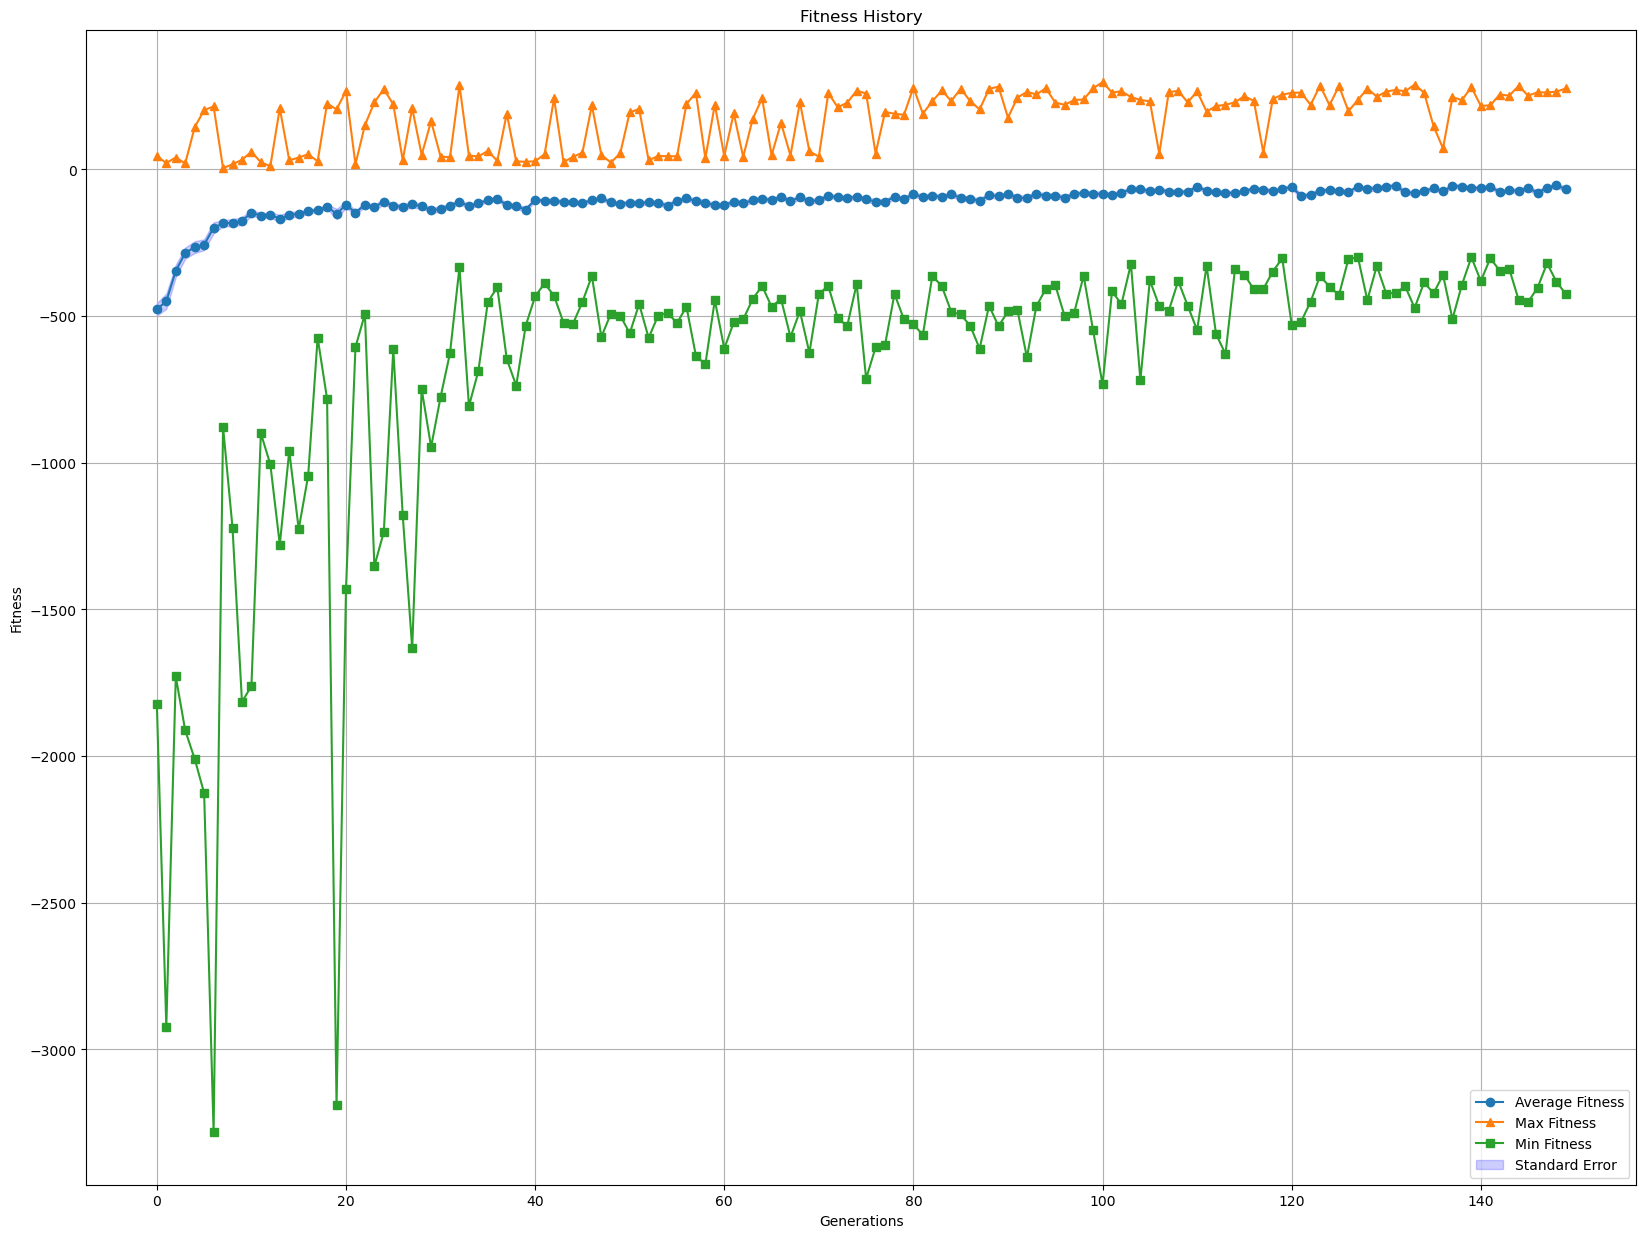

In [8]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()

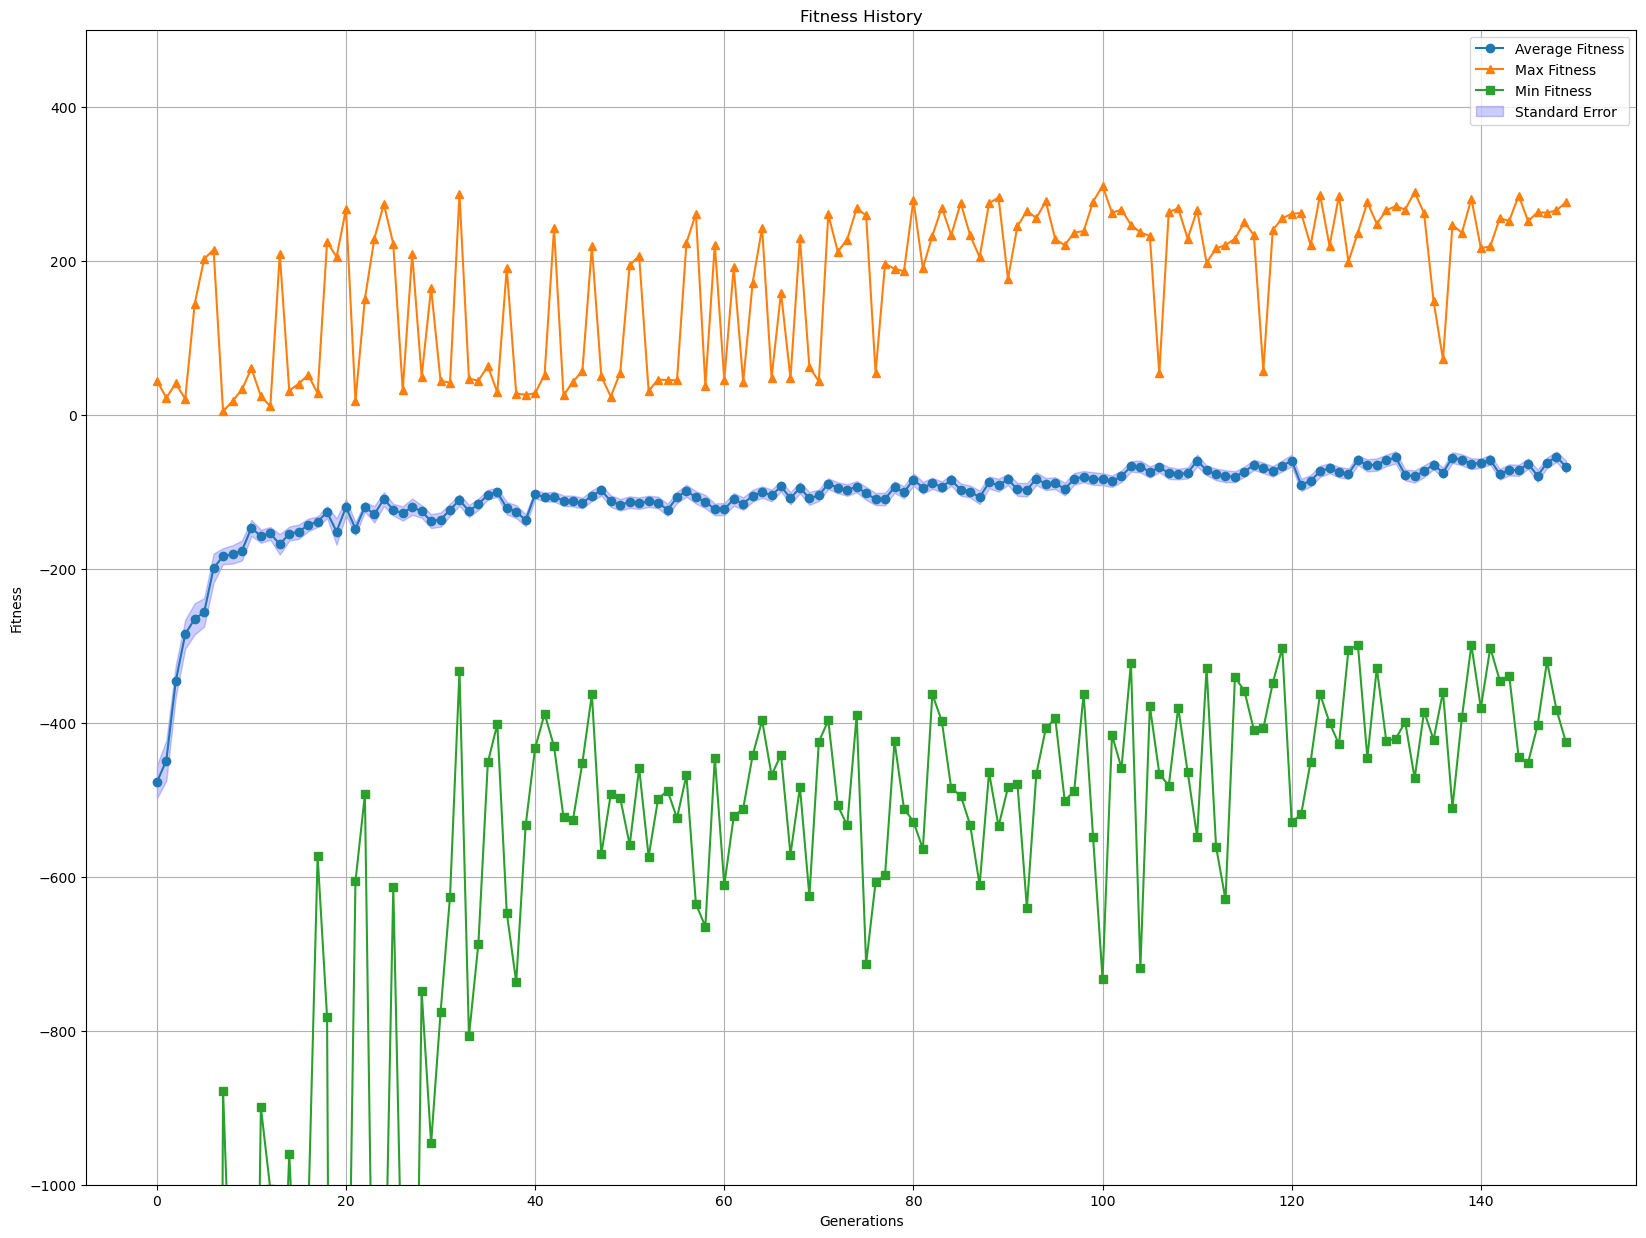

In [9]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0], marker='o', linestyle='-', label='Average Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,1], marker='^', linestyle='-', label='Max Fitness')
plt.plot(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,2], marker='s', linestyle='-', label='Min Fitness')
plt.fill_between(np.arange(GENERATIONS), np.array(FITNESS_HISTORY)[:,0] - np.array(FITNESS_STDERROR_HISTORY), np.array(FITNESS_HISTORY)[:,0] + np.array(FITNESS_STDERROR_HISTORY),
                 alpha=0.2, color='blue', label='Standard Error')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.ylim([-1000, 500])
plt.title('Fitness History')
plt.grid()
plt.legend()
plt.show()

### Visualization

In [10]:
def visualize_best_individual(network, env):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        env.render()  # Render the environment to the screen
        action = network.act(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
    print(f"Total reward: {total_reward}")
    env.close()

In [12]:
fitnesses = [calculate_fitness(network, env, MAX_EP) for network in tqdm(population, desc="Calculating fitnesses")]
population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]
best_individual = population[0]
visualize_best_individual(best_individual, env)

Calculating fitnesses: 100%|██████████████████████████████| 200/200 [00:01<00:00, 109.65it/s]


error: display Surface quit